In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat import load_generator_network, get_shallow_copy_function
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import warnings

#Disable warnings
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from matplotlib.animation import FuncAnimation
from matplotlib import colors

Using TensorFlow backend.


In [116]:

#fp = FontProperties(family="Ubuntu", weight="bold")
fp = FontProperties(family="DejaVu Sans", weight="bold")

globscale = 1.35
LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
            "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
            "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
            "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
            "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
            ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen',
                'UP': 'green', 
                'DN': 'red',
                '(': 'black',
                '.': 'black', 
                ')': 'black'}

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0) :
    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seqprop_logo_fullseq(ax_logo, pwms, cut_preds, sequence_templates=None, logo_height=1.0, plot_start=0, plot_end=164) :
    
    #Slice according to seq trim index
    pwms = pwms[:, plot_start: plot_end, :]
    cut_preds = cut_preds[:, plot_start-1: plot_end]
    sequence_templates = [sequence_template[plot_start: plot_end] for sequence_template in sequence_templates]

    pwms += 0.0001
    for j in range(0, pwms.shape[1]) :
        pwms[:, j, :] /= np.sum(pwms[:, j, :], axis=1).reshape(-1, 1)

    entropies = np.zeros(pwms.shape)
    entropies[pwms > 0] = pwms[pwms > 0] * -np.log2(pwms[pwms > 0])
    entropies = np.sum(entropies, axis=2)
    conservations = 2 - entropies
    
    for k in range(pwms.shape[0]) :
        pwm = pwms[k, :, :]
        cut_pred = cut_preds[k, :]
        sequence_template = sequence_templates[k]
        conservation = conservations[k]

        height_base = (1.0 - logo_height) / 2. + 5 * k + 0.5

        for j in range(0, pwm.shape[0]) :
            sort_index = np.argsort(pwm[j, :])

            for ii in range(0, 4) :
                i = sort_index[ii]

                nt_prob = pwm[j, i] * conservation[j]

                nt = ''
                if i == 0 :
                    nt = 'A'
                elif i == 1 :
                    nt = 'C'
                elif i == 2 :
                    nt = 'G'
                elif i == 3 :
                    nt = 'T'

                color = None
                if sequence_template[j] != 'N' :
                    color = 'black'

                if ii == 0 :
                    letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax_logo, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax_logo, color=color)

        plt.sca(ax_logo)

        plt.xlim((0, plot_end - plot_start))
        plt.ylim((-0.1, 5 * 4 + 4))
        plt.xticks([], [])
        plt.yticks([], [])
        plt.axis('off')

        #ax_logo.axhline(y=0.01 + height_base, xmin=0, color='black', linestyle='-', linewidth=2)
        ax_logo.plot([0, plot_end - plot_start], [0.01 + height_base, 0.01 + height_base], color='black', linestyle='-', linewidth=2)
        
        l2, = ax_logo.plot(np.arange(plot_end - plot_start + 1), 5 * k + 0.5 + 1.5 + cut_pred * 2., linewidth=2, linestyle='-', color='red', alpha=0.8)


In [3]:

class GenesisMonitor(Callback):
    def __init__(self, predictor_model, loss_model, track_mode='batch', batch_freq_dict=None, measure_funcs=[], batch_size=36, input_tensor_funcs=None, pwm_start=70 - 50, pwm_end=76 + 50) :
        self.predictor_model = predictor_model
        self.loss_model = loss_model
        self.track_mode = track_mode
        self.batch_freq_dict = batch_freq_dict
        self.measure_funcs = measure_funcs
        self.batch_size = batch_size
        
        self.pwm_start = pwm_start
        self.pwm_end = pwm_end
        
        self.input_tensor_funcs = input_tensor_funcs

        self.batch_history = []
        self.loss_history = []
        self.measure_history = []
        self.entropy_history = []
        self.nt_swap_history = []
        self.pwm_history = []
        self.input_history = []
        self.prev_optimized_pwm = None

        self.n_epochs = 0
        self.n_batches = 0
        
        self.batch_freq = 10
        if self.batch_freq_dict is not None and 0 in self.batch_freq_dict :
            self.batch_freq = self.batch_freq_dict[0]

        input_tensors, optimized_loss, pred_bundle = self._predict_vals()
        
        optimized_pwm = pred_bundle[3]
        optimized_measures = [measure_func(pred_bundle[9:]) for measure_func in self.measure_funcs]

        #Track metrics
        self.batch_history.append(self.n_batches)
        self._track_input_history(input_tensors)
        self._track_pwm_history(optimized_pwm)
        self._track_loss_history(optimized_loss)
        self._track_measure_history(optimized_measures)
        self._track_entropy_history(optimized_pwm)

        self.prev_optimized_pwm = optimized_pwm
        self.nt_swap_history.append(np.zeros((optimized_pwm.shape[0], 1)))
    
    def _predict_vals(self) :
        
        self.input_tensors = [self.input_tensor_funcs[i](i) for i in range(len(self.input_tensor_funcs))]
        
        optimized_loss = self.loss_model.predict(x=self.input_tensors, batch_size=self.batch_size)
        pred_bundle = self.predictor_model.predict(x=self.input_tensors, batch_size=self.batch_size)
        
        return self.input_tensors, optimized_loss, pred_bundle
    
    def _track_input_history(self, input_tensors) : 
        self.input_history.append(input_tensors)
    
    def _track_pwm_history(self, optimized_pwm) : 
        self.pwm_history.append(optimized_pwm)
    
    def _track_loss_history(self, optimized_loss) : 
        self.loss_history.append(optimized_loss)

    def _track_measure_history(self, optimized_measures) :
        self.measure_history.append(optimized_measures)

    def _track_entropy_history(self, optimized_pwm) :
        pwm_section = optimized_pwm[:, self.pwm_start:self.pwm_end, :, :]
        entropy = pwm_section * -np.log(np.clip(pwm_section, 10**(-6), 1. - 10**(-6))) / np.log(2.0)
        entropy = np.sum(entropy, axis=(2, 3))
        conservation = 2.0 - entropy
        mean_bits = np.expand_dims(np.mean(conservation, axis=-1), axis=-1)
        self.entropy_history.append(mean_bits)

    def _track_nt_swap_history(self, optimized_pwm) :
        nt_swaps = np.zeros((optimized_pwm.shape[0], 1))
        nt_swaps[:, 0] = self.nt_swap_history[-1][:, 0]

        for i in range(optimized_pwm.shape[0]) :
            for j in range(self.pwm_start, self.pwm_end) :
                curr_max_nt = np.argmax(optimized_pwm[i, j, :, 0])
                prev_max_nt = np.argmax(self.prev_optimized_pwm[i, j, :, 0])

                if curr_max_nt != prev_max_nt :
                    nt_swaps[i, 0] += 1

        self.nt_swap_history.append(nt_swaps)

    def on_batch_end(self, batch, logs={}) :
        self.n_batches += 1
        
        if batch == 0 and self.batch_freq_dict is not None and self.n_epochs in self.batch_freq_dict :
            self.batch_freq = self.batch_freq_dict[self.n_epochs]

        if self.track_mode == 'batch' and batch % self.batch_freq == 0 :
            input_tensors, optimized_loss, pred_bundle = self._predict_vals()

            optimized_pwm = pred_bundle[3]
            optimized_measures = [measure_func(pred_bundle[9:]) for measure_func in self.measure_funcs]

            #Track metrics
            self.batch_history.append(self.n_batches)
            self._track_input_history(input_tensors)
            self._track_pwm_history(optimized_pwm)
            self._track_loss_history(optimized_loss)
            self._track_measure_history(optimized_measures)
            self._track_entropy_history(optimized_pwm)

            self.prev_optimized_pwm = optimized_pwm
            self.nt_swap_history.append(np.zeros((optimized_pwm.shape[0], 1)))

            #Cache previous pwms
            self.prev_optimized_pwm = optimized_pwm

    def on_epoch_end(self, epoch, logs={}) :
        self.n_epochs += 1

        if self.track_mode == 'epoch' :
            input_tensors, optimized_loss, pred_bundle = self._predict_vals()

            optimized_pwm = pred_bundle[3]
            optimized_measures = [measure_func(pred_bundle[9:]) for measure_func in self.measure_funcs]

            #Track metrics
            self._track_input_history(input_tensors)
            self._track_pwm_history(optimized_pwm)
            self._track_loss_history(optimized_loss)
            self._track_measure_history(optimized_measures)
            self._track_entropy_history(optimized_pwm)

            self.prev_optimized_pwm = optimized_pwm
            self.nt_swap_history.append(np.zeros((optimized_pwm.shape[0], 1)))

            #Cache previous pwms
            self.prev_optimized_pwm = optimized_pwm


In [9]:

#Define target isoform loss function
def get_isoform_loss(target_isos, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=similarity_margin, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func, val_loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, val_loss_func, val_fixed_tensor_funcs, val_random_tensor_funcs, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, batch_freq_dict=None) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Validation Generator Network
    _, val_generator = get_generator_copier(generator)(batch_size, len(sequence_templates[0]), get_shallow_copy_function(generator), n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False, validation_sample_mode='sample', supply_inputs=True)
    
    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    
    _, val_predictor = build_predictor(val_generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in val_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_valversion"
    
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    _, val_loss_model = build_loss_model(val_predictor, val_loss_func)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
    
    
    get_iso_pred_func = lambda pred_outs: pred_outs[0]
    get_cut_pred_func = lambda pred_outs: pred_outs[1]
    
    fixed_genesis_monitor = GenesisMonitor(val_predictor, val_loss_model, track_mode='batch', batch_freq_dict=batch_freq_dict, measure_funcs=[get_iso_pred_func, get_cut_pred_func], batch_size=32, input_tensor_funcs=val_fixed_tensor_funcs)
    random_genesis_monitor = GenesisMonitor(val_predictor, val_loss_model, track_mode='batch', batch_freq_dict=batch_freq_dict, measure_funcs=[get_iso_pred_func, get_cut_pred_func], batch_size=32, input_tensor_funcs=val_random_tensor_funcs)
    
    #Specify callback entities
    callbacks =[
        fixed_genesis_monitor,
        random_genesis_monitor
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, sample_predictor, train_history, fixed_genesis_monitor, random_genesis_monitor


In [10]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [11]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]

margin_similarities = [
    0.5
]


In [12]:

class_list = ([0] * 128)

#Fixed validation tensors
val_fixed_tensors = [
    np.array(class_list).reshape(-1, 1),
    np.random.uniform(-1, 1, (32 * 4, 100)),
    np.random.uniform(-1, 1, (32 * 4, 100))
]

val_fixed_tensor_funcs = [
    lambda i, val_fixed_tensors=val_fixed_tensors: val_fixed_tensors[0],
    lambda i, val_fixed_tensors=val_fixed_tensors: val_fixed_tensors[1],
    lambda i, val_fixed_tensors=val_fixed_tensors: val_fixed_tensors[2]
]

#Randomized validation tensors
val_random_tensor_funcs = [
    lambda i: np.array(class_list).reshape(-1, 1),
    lambda i: np.random.uniform(-1, 1, (32 * 4, 100)),
    lambda i: np.random.uniform(-1, 1, (32 * 4, 100))
]


In [13]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 25
#Number of steps (grad updates) per epoch
steps_per_epoch = 100

batch_freq_dict = {
    0 : 1,
    1 : 5,
    5 : 10
}

print("Target iso = " + str(target_isos[0]))
    
lib_name = library_contexts[0].split("_")[0]
print("Library context = " + str(lib_name))

K.clear_session()

loss, val_loss = get_isoform_loss(
    [target_isos[0]],
    use_start=22,
    use_end=70,
    use_target_bits=1.95,
    cse_start=70,
    cse_end=76,
    cse_target_bits=1.95,
    dse_start=76,
    dse_end=121,
    dse_target_bits=1.95,
    entropy_weight=1.0,
    similarity_weight=5.0,
    similarity_margin=margin_similarities[0],
    punish_dn_cse=1.0,
    punish_up_c=0.0015,
    punish_dn_c=0.0001,
    punish_up_g=0.0001,
    punish_dn_g=0.0001,
    punish_up_aa=0.00025,
    punish_dn_aa=0.005
)

genesis_generator, genesis_predictor, train_history, fixed_genesis_monitor, random_genesis_monitor = None, None, None, None, None
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    genesis_generator, genesis_predictor, train_history, fixed_genesis_monitor, random_genesis_monitor = run_genesis([sequence_templates[0]], loss, val_loss, val_fixed_tensor_funcs, val_random_tensor_funcs, [library_contexts[0]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch, batch_freq_dict=batch_freq_dict)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_target_isoform_' + str(target_isos[0]).replace(".", "") + '_pwm_and_multisample_marginsimilarity_hardersimilarity_' + str(lib_name) + '_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_' + str(margin_similarities[0]).replace(".", "") + '_track_gif_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_target_isoform_' + str(target_isos[0]).replace(".", "") + '_pwm_and_multisample_marginsimilarity_hardersimilarity_' + str(lib_name) + '_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_' + str(margin_similarities[0]).replace(".", "") + '_track_gif_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


Training GENESIS
Target iso = 1.0
Library context = simple
Epoch 1/25
100/100 [==============================] - 54s 536ms/step - loss: 3.0301
Epoch 2/25
100/100 [==============================] - 16s 163ms/step - loss: 1.2516
Epoch 3/25
100/100 [==============================] - 16s 163ms/step - loss: 0.4983
Epoch 4/25
100/100 [==============================] - 16s 163ms/step - loss: 0.3397
Epoch 5/25
100/100 [==============================] - 16s 163ms/step - loss: 0.2714
Epoch 6/25
100/100 [==============================] - 12s 122ms/step - loss: 0.2412
Epoch 7/25
100/100 [==============================] - 12s 123ms/step - loss: 0.2068
Epoch 8/25
100/100 [==============================] - 12s 123ms/step - loss: 0.1906
Epoch 9/25
100/100 [==============================] - 12s 123ms/step - loss: 0.1681
Epoch 10/25
100/100 [==============================] - 12s 123ms/step - loss: 0.1584
Epoch 11/25
100/100 [==============================] - 12s 123ms/step - loss: 0.1416
Epoch 12/25
100

In [14]:

fixed_dict = {}

fixed_dict['batch_history'] = fixed_genesis_monitor.batch_history
fixed_dict['pwm_history'] = fixed_genesis_monitor.pwm_history
fixed_dict['seed_history'] = fixed_genesis_monitor.input_history
fixed_dict['loss_history'] = fixed_genesis_monitor.loss_history
fixed_dict['entropy_history'] = fixed_genesis_monitor.entropy_history
fixed_dict['nt_swap_history'] = fixed_genesis_monitor.nt_swap_history
fixed_dict['measure_history'] = fixed_genesis_monitor.measure_history

random_dict = {}

random_dict['batch_history'] = random_genesis_monitor.batch_history
random_dict['pwm_history'] = random_genesis_monitor.pwm_history
random_dict['seed_history'] = random_genesis_monitor.input_history
random_dict['loss_history'] = random_genesis_monitor.loss_history
random_dict['entropy_history'] = random_genesis_monitor.entropy_history
random_dict['nt_swap_history'] = random_genesis_monitor.nt_swap_history
random_dict['measure_history'] = random_genesis_monitor.measure_history


In [15]:
import pickle

fixed_genesis_monitor.predictor_model = None
fixed_genesis_monitor.loss_model = None

random_genesis_monitor.predictor_model = None
random_genesis_monitor.loss_model = None

pickle.dump({'fixed_seeds' : fixed_dict, 'random_seeds' : random_dict}, open('genesis_max_isoform_simple_monitors.pickle', 'wb'))


In [19]:

genesis_monitors = pickle.load(open('genesis_max_isoform_simple_monitors.pickle', 'rb'))

fixed_genesis_monitor = genesis_monitors['fixed_seeds']
random_genesis_monitor = genesis_monitors['random_seeds']


In [112]:
#Make GIFs for fixed seed configuration

pwm_history = fixed_genesis_monitor['pwm_history']
flat_pwm_history = []

for step_index in range(0, len(pwm_history)) :
    
    pwms = pwm_history[step_index]
    
    flat_pwms = np.zeros((pwms.shape[0], 205))
    
    for i in range(pwms.shape[0]) :
        for j in range(205) :
            max_nt_ix = np.argmax(pwms[i, j, :, 0])
            flat_pwms[i, j] = max_nt_ix + 1
    
    flat_pwms = flat_pwms[:, 70-45: 76+45]
    flat_pwm_history.append(flat_pwms)

batch_history = fixed_genesis_monitor['batch_history']
seed_history = fixed_genesis_monitor['seed_history']
loss_history = fixed_genesis_monitor['loss_history']
entropy_history = fixed_genesis_monitor['entropy_history']
nt_swap_history = fixed_genesis_monitor['nt_swap_history']
measure_history = fixed_genesis_monitor['measure_history']

min_loss = np.min(np.array([np.min(loss_history[i]) for i in range(len(loss_history))]))
max_loss = np.max(np.array([np.max(loss_history[i]) for i in range(len(loss_history))]))

min_iso = np.min(np.array([np.min(measure_history[i][0]) for i in range(len(loss_history))]))
max_iso = np.max(np.array([np.max(measure_history[i][0]) for i in range(len(loss_history))]))

sel_pwm_history = [
    temp_pwms[[0, 8, 20, 24, 50][::-1], :, :, 0]
    for temp_pwms in pwm_history
]

sel_cut_history = [
    temp_meas[1][[0, 8, 20, 24, 50][::-1], 0, 0:205]
    for temp_meas in measure_history
]


In [113]:

logodds_history = []

for i in range(len(loss_history)) :
    iso_vec = measure_history[i][0]
    
    logodds_history.append(np.log(iso_vec / (1. - iso_vec)))

min_logodds = np.min(np.array([np.min(logodds_history[i]) for i in range(len(logodds_history))]))
max_logodds = np.max(np.array([np.max(logodds_history[i]) for i in range(len(logodds_history))]))


In [114]:

sequence_templates = [sequence_templates[0]] * 5


Grabbing frame 0...
Grabbing frame 10...
Grabbing frame 20...
Grabbing frame 30...
Grabbing frame 40...
Grabbing frame 50...
Grabbing frame 60...
Grabbing frame 70...
Grabbing frame 80...
Grabbing frame 90...
Grabbing frame 100...
Grabbing frame 110...
Grabbing frame 120...
Grabbing frame 130...
Grabbing frame 140...
Grabbing frame 150...
Grabbing frame 160...
Grabbing frame 170...
Grabbing frame 180...
Grabbing frame 190...
Grabbing frame 200...
Grabbing frame 210...
Grabbing frame 220...
Grabbing frame 230...
Grabbing frame 240...
Grabbing frame 250...
Grabbing frame 260...
Grabbing frame 270...
Grabbing frame 280...
Grabbing frame 290...
Grabbing frame 300...
Grabbing frame 310...
Grabbing frame 320...
Grabbing frame 330...
Grabbing frame 340...
Grabbing frame 350...
Grabbing frame 360...
Grabbing frame 370...
Grabbing frame 380...


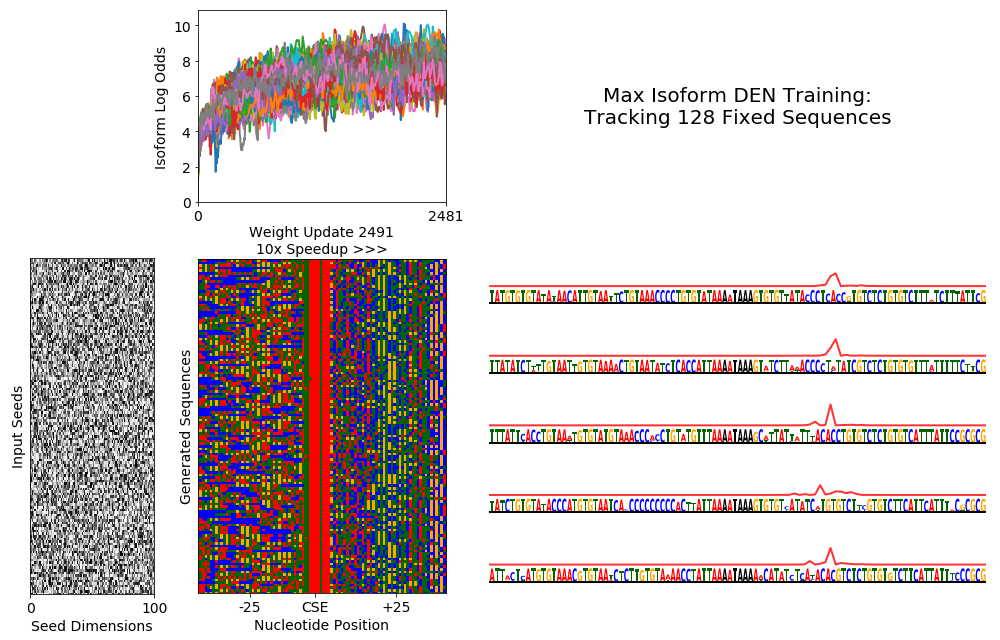

In [121]:

#(Fixed Seed) Animation 5: Seeds, Diversity Grid and Loss Function with Full Sequence PWM

n_classes = 1
n_frames = len(batch_history) - 1

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

w = flat_pwm_history[0].shape[1]
n_seqs = 128

f, ax = plt.subplots(2, 3, figsize=(14, 9), gridspec_kw={'width_ratios': [2, 4, 8], 'height_ratios': [2, 3.5]})

ax[0, 0].axis('off')

title_str = "Max Isoform DEN Training:\nTracking " + str(n_seqs) + " Fixed Sequences"
ax[0, 2].text(0.5, 0.5, title_str, {'color': 'black', 'fontsize': 20}, horizontalalignment='center', verticalalignment='center', transform=ax[0, 2].transAxes)



#Plot PWMs
ax[0, 2].axis('off')
ax[1, 2].axis('off')

ax[1, 2].get_xaxis().set_visible(False)
ax[1, 2].get_yaxis().set_visible(False)

plot_seqprop_logo_fullseq(ax[1, 2], sel_pwm_history[380], sel_cut_history[380], sequence_templates=sequence_templates, logo_height=0.5, plot_start=70-45, plot_end=76+45)


'''
loss_lines = []
for i in range(loss_history[0].shape[0]) :
    line, = ax[0, 1].plot([], [], linewidth=2)
    loss_lines.append(line)

plt.sca(ax[0, 1])
plt.ylabel("Loss", fontsize=14)

plt.xticks([0, batch_history[n_frames-1]], [0, batch_history[n_frames-1]], fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, batch_history[n_frames-1])
plt.ylim(min_loss - 0.02 * min_loss * np.sign(min_loss), max_loss + 0.02 * max_loss * np.sign(max_loss))
'''

loss_lines = []
for i in range(n_seqs) :
    line, = ax[0, 1].plot([], [], linewidth=2)
    loss_lines.append(line)

plt.sca(ax[0, 1])
plt.ylabel("Isoform Log Odds", fontsize=14)

plt.xticks([0, batch_history[n_frames-1]], [0, batch_history[n_frames-1]], fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, batch_history[n_frames-1])
#plt.ylim(min_logodds - 0.08 * min_logodds * np.sign(min_logodds), max_logodds + 0.02 * max_logodds * np.sign(max_logodds))
plt.ylim(0., max_logodds + 0.02 * max_logodds * np.sign(max_logodds))

seed_image = ax[1, 0].imshow(seed_history[0][1][:n_seqs, :], aspect='auto', interpolation='nearest', origin='lower', cmap='Greys', vmin=-1.0, vmax=1.0)

plt.sca(ax[1, 0])
plt.xlabel("Seed Dimensions", fontsize=14)
plt.ylabel("Input Seeds", fontsize=14)

plt.xticks([0, 100], [0, 100], fontsize=14)
plt.yticks([], [], fontsize=14)
plt.xlim(0, 100)
plt.ylim(0, n_seqs)



image = ax[1, 1].imshow(flat_pwm_history[0][:n_seqs, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.sca(ax[1, 1])
plt.xlabel("Nucleotide Position", fontsize=14)
plt.ylabel("Generated Sequences", fontsize=14)

plt.xticks([45 - 25, 45, 45 + 6 + 25], ["-25", "CSE", "+25"], fontsize=14)
plt.yticks([], [])
plt.xlim(0, w-1)
plt.ylim(0, n_seqs)

plt.title("Weight Update 0\n1x Speedup >", fontsize=14)

plt.tight_layout()

plt.subplots_adjust(wspace=0.15)

loss_data_x = [[0] for i in range(n_seqs)]
loss_data_y = [[np.mean(logodds_history[0][i])] for i in range(n_seqs)]

def init() :
    for i in range(n_seqs) :
        loss_lines[i].set_data([], [])
    
    image.set_data(flat_pwm_history[0][:n_seqs, :])
    
    return image,

def animate(t) :
    if t % 10 == 0 :
        print("Grabbing frame " + str(t) + "...")
    
    if t > 0 :
        for i in range(n_seqs) :
            loss_data_x[i].append(batch_history[t])
            loss_data_y[i].append(np.mean(logodds_history[t][i]))
            
            loss_lines[i].set_data(loss_data_x[i], loss_data_y[i])
    
    seed_image.set_data(seed_history[t][1][:n_seqs, :])
    
    image.set_data(flat_pwm_history[t][:n_seqs, :])
    
    curr_speed = 1
    speed_sign = ">"
    if t > 0 :
        curr_speed = int(batch_history[t] - batch_history[t-1])
        if curr_speed <= 1 :
            speed_sign = ">"
        elif curr_speed > 1 and curr_speed <= 5 :
            speed_sign = ">>"
        elif curr_speed > 5 :
            speed_sign = ">>>"
    
    ax[1, 1].set_title("Weight Update " + str(batch_history[t]) + "\n" + str(curr_speed) + "x Speedup " + speed_sign, fontsize=14)
    
    ax[1, 2].clear()
    ax[1, 2].axis('off')
    
    plot_seqprop_logo_fullseq(ax[1, 2], sel_pwm_history[t], sel_cut_history[t], sequence_templates=sequence_templates, logo_height=0.5, plot_start=70-45, plot_end=76+45)
    
    return image,


anim = FuncAnimation(f, animate, init_func=init, frames=n_frames+1, interval=50, blit=True)

anim.save('genesis_max_isoform_simple_fixed_sequences_with_seeds_and_pwms_all.gif', writer='imagemagick')

